# VQA Run
### This code uses pretrained VQA (checkpoints in models folder) to allow new questions to be asked to the model.

In [13]:
import os

import torch
import numpy as np
import matplotlib.pyplot as plt

from models import VqaModel
from data_loader import get_loader

from PIL import Image
import torchvision.transforms as transforms
from utils import text_helper
from ipywidgets import widgets


# Stdlib imports
from io import BytesIO
import PIL.Image
# Third-party libraries
from IPython.display import Image
from ipywidgets import interact, fixed
import matplotlib as mpl
from skimage import io, img_as_float
import numpy as np
import pandas as pd
import re
from ipywidgets import FloatSlider, IntSlider, Text

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
vqa = np.load('./datasets/valid.npy', allow_pickle=True)
print(f'Size of the dataset: {len(vqa)}')

Size of the dataset: 214354


### The VQA dataset is a dictionary that has the following keys
['image_name', 'image_path', 'question_id', 'question_str', 'question_tokens', 'all_answers', 'valid_answers']

In [4]:
idx = 0
vqa[idx].keys()

dict_keys(['image_name', 'image_path', 'question_id', 'question_str', 'question_tokens', 'all_answers', 'valid_answers'])

### Here is one sample image from the dataset with the respective answers

 Image id: 100230


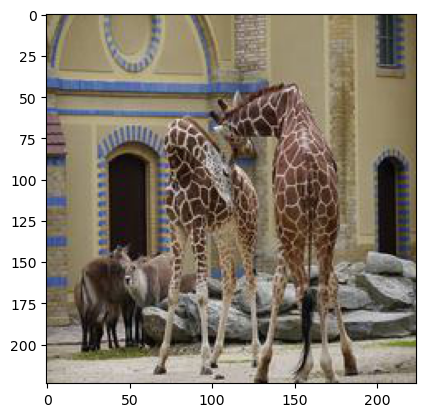

{'image_name': 'COCO_val2014_000000318039', 'image_path': '/C/lucas/basic_vqa/datasets/Resized_Images/val2014/COCO_val2014_000000318039.jpg', 'question_id': 318039001, 'question_str': 'What color are the giraffes?', 'question_tokens': ['what', 'color', 'are', 'the', 'giraffes', '?'], 'all_answers': ['brown', 'brown', 'brown and white', 'brown and tan', 'brown', 'brown and white', 'yellow and brown', 'brown', 'brown', 'tan and brown'], 'valid_answers': ['brown', 'brown', 'brown and white', 'brown', 'brown and white', 'brown', 'brown']}


In [5]:
idx = 100230
print(f' Image id: {idx}')
plt.figure()
image = io.imread(vqa[idx]['image_path'])
plt.imshow(image)
plt.show()
print(vqa[idx])

### Create the model and the loader

In [6]:
data_loader = get_loader(
    input_dir='./datasets',
    input_vqa_train='train.npy',
    input_vqa_valid='valid.npy',
    max_qst_length=30,
    max_num_ans=10,
    batch_size=256,
    num_workers=8)

qst_vocab_size = data_loader['train'].dataset.qst_vocab.vocab_size
ans_vocab_size = data_loader['train'].dataset.ans_vocab.vocab_size
ans_unk_idx = data_loader['train'].dataset.ans_vocab.unk2idx


model = VqaModel(
    embed_size=1024,
    qst_vocab_size=qst_vocab_size,
    ans_vocab_size=ans_vocab_size,
    word_embed_size=300,
    num_layers=2,
    hidden_size=512).to(device)

/C/lucas/conda_envs/vqa/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/C/lucas/conda_envs/vqa/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Load the pretrained checkpoint

In [7]:
model.load_state_dict(torch.load('models/model-epoch-30.ckpt')['state_dict'])
model.eval()


VqaModel(
  (img_encoder): ImgEncoder(
    (model): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1,

In [18]:
trans_pipeline = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406),
                                                        (0.229, 0.224, 0.225))]) 

input_dir = './datasets' 
qst_vocab = text_helper.VocabDict(input_dir+'/vocab_questions.txt')
ans_vocab = text_helper.VocabDict(input_dir+'/vocab_answers.txt')

def apply_color_transf(image,conv_matrix,grayscale=False):
    image = image.convert('RGB', conv_matrix)
    return image

def tokenize_question(question):
    SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
    question = SENTENCE_SPLIT_REGEX.split(question.lower())
    #print(question)
    question = [w.strip() for w in question if len(w.strip()) > 0]
    #print(question)

    qst2idc = np.array([qst_vocab.word2idx('<pad>')] * 30)  # padded with '<pad>' in 'ans_vocab'
    qst2idc[:len(question)] = [qst_vocab.word2idx(w) for w in question]
    return qst2idc


def make_prediction(image, tokenized_question):
    sample = {'image': image, 'question': tokenized_question}
    sample['image'] = trans_pipeline(sample['image'])
    
    sample['image'] = torch.as_tensor(sample['image'].clone()).to(device)
    sample['image'] = sample['image'][None,:,:,:]
    sample['question'] = torch.tensor(sample['question']).to(device)
    sample['question'] = sample['question'][None, :]
    output = model(sample['image'],sample['question'])
    return [ans_vocab.idx2word(w) for w in torch.topk(output.flatten(),5).indices]

In [19]:
def arr2img(arr):
    """Display a 2- or 3-d numpy array as an image."""
    if arr.ndim == 2:
        format, cmap = 'png', mpl.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'jpg', None
    else:
        raise ValueError("Only 2- or 3-d arrays can be displayed as images.")
    # Don't let matplotlib autoscale the color range so we can control overall luminosity
    vmax = 255 if arr.dtype == 'uint8' else 1.0
    with BytesIO() as buffer:
        mpl.image.imsave(buffer, arr, format=format, cmap=cmap, vmin=0, vmax=vmax)
        out = buffer.getvalue()
    return Image(out)

def edit_image(image, R=1.0, G=1.0, B=1.0, img_index=500, question=''):
    image = df_vqa.iloc[img_index]['image_path']
    image = PIL.Image.open(image).convert('RGB')
    new_image = np.array(image.copy())
    new_image[:,:,0] = R*new_image[:,:,0]
    new_image[:,:,1] = G*new_image[:,:,1]
    new_image[:,:,2] = B*new_image[:,:,2]

    question=question.strip()
    if len(question) > 0 and question[-1] == '?':
       tokenized_question = tokenize_question(question)
       print('Predicted Answers:', end='\n  ')
       print(make_prediction(new_image, tokenized_question),sep='\n  ',end='\n\n')

    print('Questions:', end='\n  ')
    print(*df_vqa.iloc[img_index]['question_str'],sep='\n  ')
    print('All Answers:', end='\n  ')
    print(*df_vqa.iloc[img_index]['all_answers'],sep='\n  ')
    print('Valid Answers:', end='\n  ')
    print(*df_vqa.iloc[img_index]['valid_answers'],sep='\n  ')


    return arr2img(new_image)

df_vqa = pd.DataFrame(list(vqa[:]))
df_vqa = df_vqa.groupby('image_path').aggregate(list)
df_vqa.drop(columns=['image_name'], inplace=True)
df_vqa.reset_index(inplace=True)

image = df_vqa.iloc[500]['image_path']
image = PIL.Image.open(image).convert('RGB')

red = FloatSlider(min=0.1, max=1.8, step=0.1,  continuous_update=False)
blue = FloatSlider(min=0.1, max=1.8, step=0.1, continuous_update=False)
green = FloatSlider(min=0.1, max=1.8, step=0.1, continuous_update=False)
red.value = 1
blue.value = 1
green.value = 1
img_slider = IntSlider(min=0, max=len(df_vqa), step=1, continuous_update=False)
question_text = Text(
    value='',
    placeholder='Type something',
    description='String:',
    continuous_update=False,
    disabled=False
)
interact(edit_image, image=fixed(np.array(image)), R=red, G=green, B=blue, img_index=img_slider, question=question_text);


interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='R', max=1.8, min=0.1), Floa…